Demo of current progress with Dataoob

In [1]:
# Imports
import numpy as np
import torch
from matplotlib import pyplot as plt

Global state

In [2]:
device = torch.device("cpu")
random_state = 10

Loading Data

In [3]:
from dataoob.dataloader.loader import DataLoader, mix_labels
from dataoob.evaluator.evaluator import EvaluatorPipeline, DataLoaderArgs

iris_args = DataLoaderArgs(
    dataset="iris", 
    force_download=False, 
    train_count=100, 
    valid_count=50, 
    add_noise_func=mix_labels, 
    noise_kwargs={'noise_rate': .25},
    device=device, 
    random_state=random_state
)
# Equivalent arguments
loader = (
    DataLoader("iris", False, device, random_state)
    .split_dataset(100, 50)
    .noisify(mix_labels, noise_rate=0.25)
)
num_points = len(loader.x_train)
covar_dim = len(loader.x_train[0])
label_dim = loader.y_train.shape[1]

Setting up the models and default arguments

Import models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from dataoob.model import ClassifierSkLearnWrapper, ClassifierUnweightedSkLearnWrapper
from dataoob.model.logistic_regression import LogisticRegression as LR
from dataoob.model.ann import ANN

In [5]:
models = {
    # Wrappers for sklearn modles, makes the api more cohesive
    'sklogreg': ClassifierSkLearnWrapper(LogisticRegression(), label_dim, device=device),
    'logreg': LR(covar_dim, label_dim).to(device),
    'ann': ANN(covar_dim, label_dim).to(device),
    'skknn': ClassifierUnweightedSkLearnWrapper(KNeighborsClassifier(label_dim), label_dim, device=device)
}

Selecting your metrics and model

In [6]:
from dataoob.evaluator.evaluator import DataEvaluatorArgs
model_name = "logreg"
metric_name = "accuracy"
train_kwargs = {"epochs": 40, "batch_size": 20} if model_name in ("ann", "logreg") else {}

de_args = DataEvaluatorArgs(
    pred_model=models[model_name],
    metric_name=metric_name,
    train_kwargs=train_kwargs,
)

Base line model performance

In [7]:
import copy
from dataoob.evaluator.evaluator import metrics_dict
model = copy.deepcopy(models[model_name])
x_train, y_train, x_valid, y_valid = loader.datapoints
model.fit(x_train, y_train, **train_kwargs)
metric = metrics_dict[metric_name]

metric(y_valid, model.predict(x_valid))

0.9399999976158142

Data Evaluators present

Import data evaluators

In [8]:
from dataoob.dataval.dvrl.dvrl import DVRL
from dataoob.dataval.shap.loo import LeaveOneOut
from dataoob.dataval.oob.oob import DataOob
from dataoob.dataval.knnshap.knnshap import KNNShapley
from dataoob.dataval.shap.datashap import DataShapley
from dataoob.dataval.shap.betashap import BetaShapley
from dataoob.dataval.shap.banzhaf import DataBanzhaf
from dataoob.dataval.dummy import DummyEvaluator
from dataoob.dataval.ame.ame import BaggingEvaluator, AME

In [9]:
dummy_eval = [  # Used for quick testing and run throughs
    DataOob(10, random_state=random_state),
    DVRL(10, rl_epochs=10, random_state=random_state),
    LeaveOneOut(random_state=random_state),
    AME(10, random_state=random_state),
    DataBanzhaf(samples=10, random_state=random_state),
    BetaShapley(100, min_samples=99, model_name="t", random_state=random_state),
    DataShapley(model_name="t", random_state=random_state),
    DataShapley(100, min_samples=99, model_name="r", random_state=random_state),
    DummyEvaluator(random_state=random_state)
]

data_evaluators = [  # actual run through of experiments, will take long time 
    DataOob(random_state=random_state),
    DVRL(rl_epochs=2000, random_state=random_state),
    LeaveOneOut(random_state=random_state),
    AME(random_state=random_state),
    DataBanzhaf(2000, random_state=random_state),
    # BetaShapley(model_name="t", random_state=random_state),
    # DataShapley(model_name="t", random_state=random_state),
]

Setting up the Evaluator Pipeline

In [10]:
evalpipe = EvaluatorPipeline.setup(iris_args, de_args, data_evaluators)
# evalpipe = EvaluatorPipeline(
#     loader, dummy_eval, pred_model=models[model_name], train_kwargs=train_kwargs
# )

100%|██████████| 2000/2000 [01:33<00:00, 21.49it/s]


Plotting and getting results

In [ ]:
# Imports
from dataoob.evaluator.exper_methods import (
    discover_corrupted_sample, noisy_detection, remove_high_low, point_addition
)

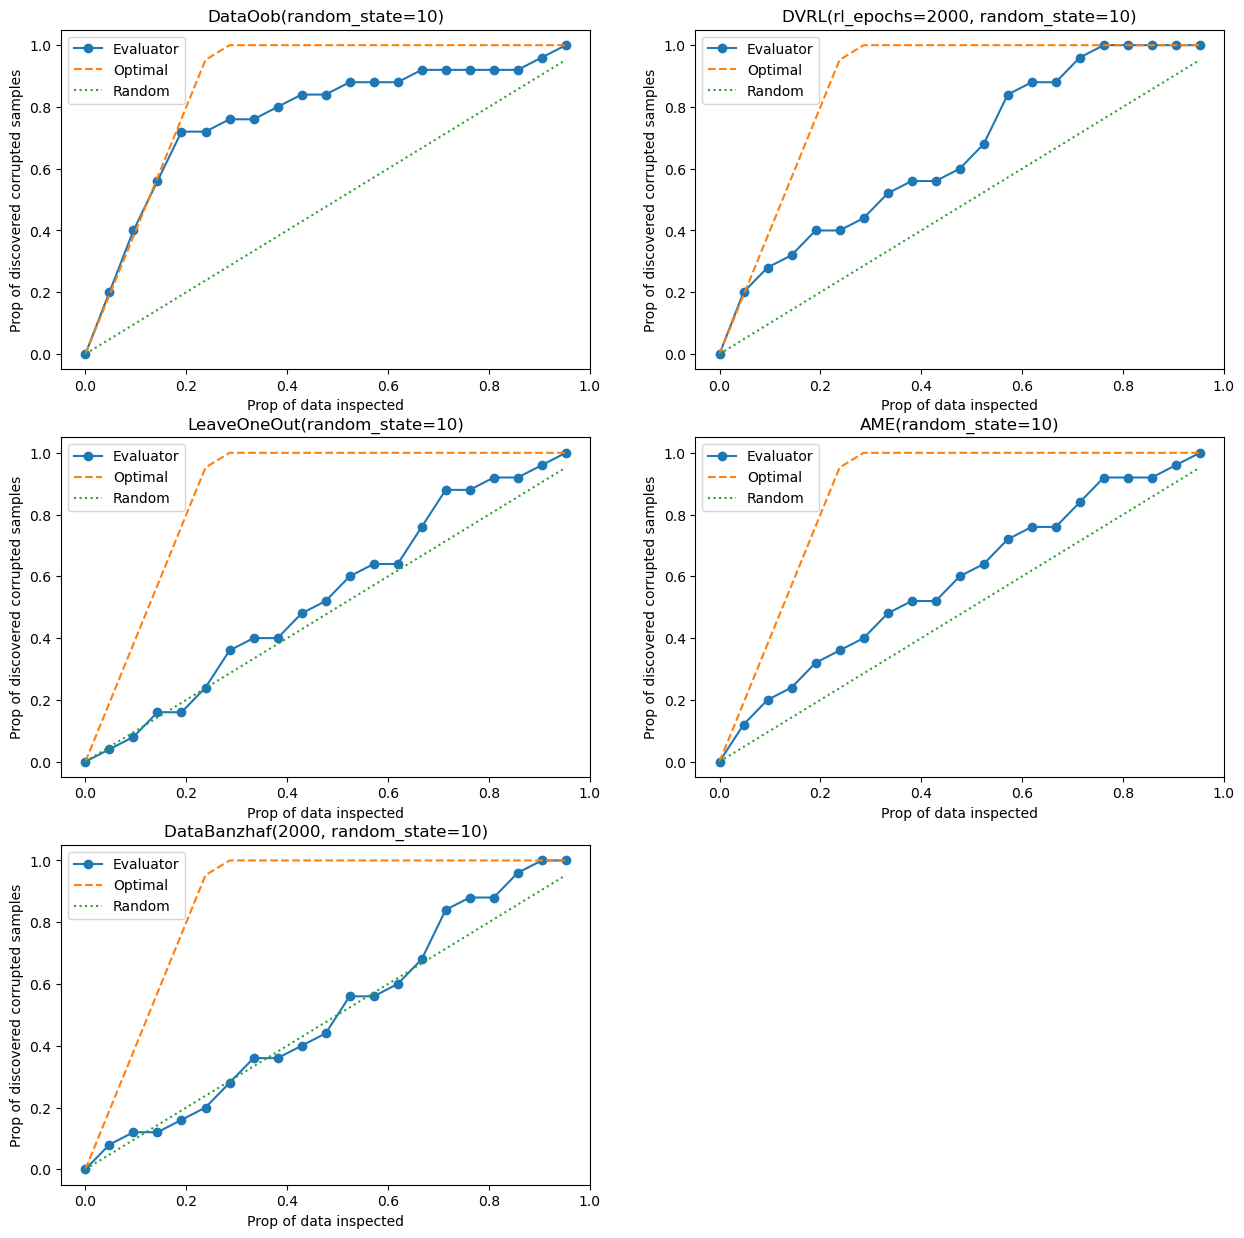

In [ ]:
fig = plt.figure(figsize=(15, 15))
df_resp = evalpipe.plot(discover_corrupted_sample, fig, col=2)
df_resp[0].to_csv("csv/discover_corrupted_sample.csv")

In [ ]:
df_resp = evalpipe.evaluate(noisy_detection)
df_resp.to_csv('csv/noisy_detection.csv')
df_resp

0
recall    DataOob(random_state=10)               0.720000
          DVRL(rl_epochs=2000, random_state=10)  0.520000
          LeaveOneOut(random_state=10)           0.240000
          AME(random_state=10)                   0.360000
          DataBanzhaf(2000, random_state=10)     0.200000
kmeans_f1 DataOob(random_state=10)               0.905405
          DVRL(rl_epochs=2000, random_state=10)  0.214286
          LeaveOneOut(random_state=10)           0.317460
          AME(random_state=10)                   0.412371
          DataBanzhaf(2000, random_state=10)     0.433962